In [1]:
%load_ext autoreload
%autoreload 2

import os, sys
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch import nn
from tqdm import tqdm
import pandas as pd

import torch.nn.functional as F
import pytorch_lightning as pl

sys.path.append(os.path.join(os.getcwd(), '../symlie'))
sys.path.append(os.path.join(os.getcwd(), '../sympdee/sympde/viz'))
sys.path.append(os.path.join(os.getcwd(), '..'))

from symlie.model.networks.linear import CalculatedP, LinearP
from sympdee.sympde.viz.general_plots import imshows, plot_vals, simple_imshow, savefig, simple_imshow, imshow
from symlie.misc.utils_results import get_and_check_Ps, plot_seeds_and_Ps
from symlie.data.transforms import Transform
from symlie.model.networks.implicit import LinearImplicit
from symlie.model.setup import load_implicitP_statedict
from symlie.model.loss import mmd
from symlie.run import parse_options, main, process_args


In [2]:
def plot_2columns(x_plots, x_titles):

    nrows = len(x_plots)
    batch_size = x_plots[0][0].shape[0]

    x_idx = np.random.randint(0, batch_size, 1)[0]
    fig, axs = plt.subplots(nrows, 2, figsize = (6, 1.*nrows), tight_layout = True)
    for i, (x_l, x_r) in enumerate(x_plots):

        x_l, x_r = x_l.detach().cpu().numpy(), x_r.detach().cpu().numpy()

        for j, (x_lr, color) in enumerate(zip([x_l, x_r], ['tab:blue', 'tab:orange'])):
            xx = x_lr[x_idx]
            ax = axs[i, j]
            ax.plot(xx, 'o-', color = color)
            ax.plot([len(xx)-1, len(xx)], [xx[-1], xx[0]], '--', color=color)
            ax.plot([-1, 0], [xx[-1], xx[0]], '--', color=color)
            ax.set_xticks([])
            ax.set_yticks([0])
            ax.set_title(x_titles[i][j])
    plt.show()

In [7]:
args = parse_options(notebook=True)

args.noise_std = 1.
args.grid_size = (1, 7)
args.eps_mult = [0.0, 0.0, 1.0, 0.0]
args.data_dir = '../data/noise'
args.net = 'TrainP'

args.do_return = True
args.logger = None

args.n_train = 16*1000

process_args(args)

# Training
model, trainer, datamodule = main(args)
size = np.prod(args.grid_size)


Seed set to 42


Running without logging


In [4]:
trainloader = datamodule.train_dataloader()

In [9]:
class TransformationLearner(nn.Module):
  
  def __init__(self, size=3):
    super().__init__()
    self.size = size
    features = size**2
    self.layers = nn.Sequential(
      nn.Linear(features,features),
      nn.ReLU(),
      nn.Linear(features,features),
      nn.ReLU(),
      nn.Linear(features,features),
      nn.ReLU(),
      nn.Linear(features,features),
    )
    
  def forward(self, x):
    x = x.view(self.size**2)
    x = self.layers(x)
    x = x.view(self.size, self.size)
    return x

In [5]:


torch.manual_seed(torch.randint(0, 1000, (1,)).item())

size = 7
# Initialize the MLP
f = TransformationLearner(size=size)

# Define the loss function and optimizer
criterion     = nn.MSELoss()
optimizer = torch.optim.Adam(f.parameters(), lr=1e-3)

losses = []

# Run the training loop
for epoch in tqdm(range(0, 15)): # 5 epochs at maximum
    
    current_loss = 0.0
    
    # Iterate over the DataLoader for training data
    for i, data in enumerate(trainloader, 0):
      
        # Get inputs
        x, _, _ = data
        batch_size = x.size(0)
        
        # Zero the gradients
        optimizer.zero_grad()

        weight = torch.rand(size, size)

        x_a = x
        x_b = x
        shift = (torch.rand((1))*size).int().item()

        o_a = x_a @ f(weight).T
        o_a_prime = torch.roll(o_a, shift, 1)

        x_b_prime = torch.roll(x_b, shift, 1)
        o_b_prime = x_b_prime @ f(weight).T

        # Compute loss
        loss = criterion(o_a_prime, o_b_prime)

        # Perform backward pass
        loss.backward()
        
        # Perform optimization
        optimizer.step()
        
        # Print statistics
        current_loss += loss.item()
    current_loss = current_loss / len(trainloader)
    losses.append(current_loss)
    

100%|██████████| 15/15 [00:14<00:00,  1.02it/s]


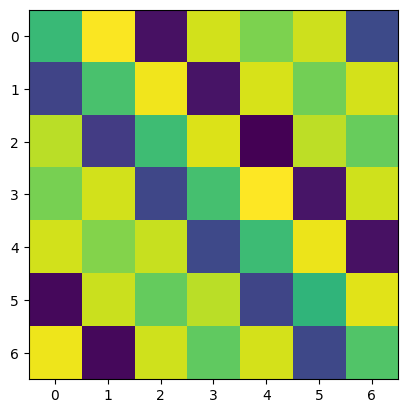

In [12]:
weight = torch.rand(size, size)
plt.imshow( f(weight).detach().cpu().numpy() )


In [13]:
x_plots = [
    [x_a, x_b_prime],
    [o_a_prime, o_b_prime],
]

x_titles = [
    ['x_a', 'x_b_prime'],
    ['out_a_prime', 'out_b_prime'],
]

plot_2columns(x_plots, x_titles)


NameError: name 'x_a' is not defined

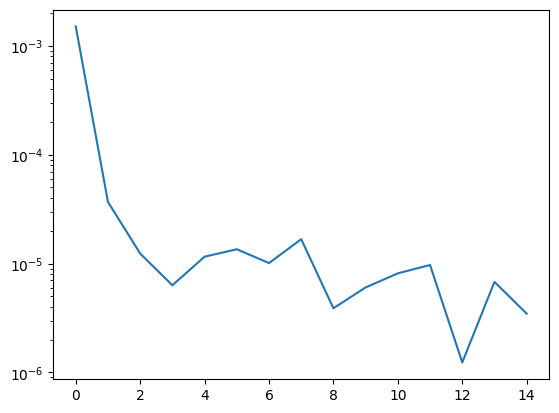

In [8]:
plt.plot(losses, label='o')
plt.yscale('log')
plt.show()

## Step 2

In [14]:
f.eval();

In [15]:
args = parse_options(notebook=True)

args.noise_std = 1.
args.grid_size = (1, 7)
args.eps_mult = [0.0, 0.0, 1.0, 0.0]
args.net = 'TrainP'
args.data_dir = '../data/sine1d'
args.y_low = 1
args.y_high = 3
args.noise_std = 0.5

args.do_return = True
args.logger = None

args.n_train = 100

process_args(args)

# Training
_, _, datamodule2 = main(args)

n_epochs = 1000

Seed set to 42


Running without logging


/Users/elias/anaconda3/envs/sympde/lib/python3.10/site-packages/pytorch_lightning/trainer/setup.py:187: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.


In [16]:
trainloader2 = datamodule2.train_dataloader()
testloader2 = datamodule2.test_dataloader()
transform_funcs = {k: v() for k, v in CalculatedP(size = size).transform_funcs.items()}

In [19]:

transform_funcs['none'].shape
seeds = [41, 42, 43]
methods = ['none', 'space_translation', 'mlp']

rs = []

for seed in seeds:
  torch.manual_seed(seed)
  for method in methods:

    if method == 'none':
      def f_eval(w):
        w = w.view(size**2)
        w = transform_funcs[method] @ w
        w = w.view(size, size)
        return w
    if method == 'space_translation':
      def f_eval(w):
        w = w.view(size**2)
        w = transform_funcs[method] @ w
        w = w.view(size, size)
        return w
    if method == 'mlp':
      def f_eval(w):
        # f = fs[seed]
        w = f(w)
        return w

    class PredictionLearner(nn.Module):
      def __init__(self, size):
        super().__init__()
        self.size = size

        self.weight1 = nn.Parameter(torch.rand(size, size))
        
        self.activation = nn.ReLU()
        self.layer2 = nn.Linear(size, 1, bias = False)

        
      def forward(self, x):
          
          weight = f_eval(self.weight1)
          x = x @ weight.T

          x = self.activation(x)
          x = self.layer2(x)
          return x

    # Initialize the MLP
    size = 7
    mlp = PredictionLearner(size=size)

    # Define the loss function and optimizer
    criterion     = nn.MSELoss()
    optimizer = torch.optim.Adam(mlp.parameters(), lr=1e-3)

    losses = []

    # Run the training loop
    for epoch in tqdm(range(0, n_epochs)): # 5 epochs at maximum
        
        current_loss = 0.0
        
        # Iterate over the DataLoader for training data
        for i, data in enumerate(trainloader2, 0):
          
            # Get inputs
            x, y, _ = data
            batch_size = x.size(0)
            
            # Zero the gradients
            optimizer.zero_grad()

            y_pred = mlp(x)


            # Compute loss
            loss = criterion(y_pred, y)

            # Perform backward pass
            loss.backward()
            
            # Perform optimization
            optimizer.step()
            
            # Print statistics
            current_loss += loss.item()
        current_loss = current_loss / len(trainloader2)
        losses.append(current_loss)

    mlp = mlp.eval()
    test_loss = 0.0
    for i, data in enumerate(testloader2, 0):
      x, y, _ = data
      y_pred = mlp(x)

      loss = criterion(y_pred, y)

      test_loss += loss.item() / len(testloader2)

    r = {
        'seed': seed,
        'method': method,
        'test_loss': test_loss,
        'losses': losses,
    }
    rs.append(r)

    # plot1d(losses, logy = True, title = f'{method}, seed={seed}, loss={losses[-1]:.6f}')

100%|██████████| 1000/1000 [00:03<00:00, 271.52it/s]


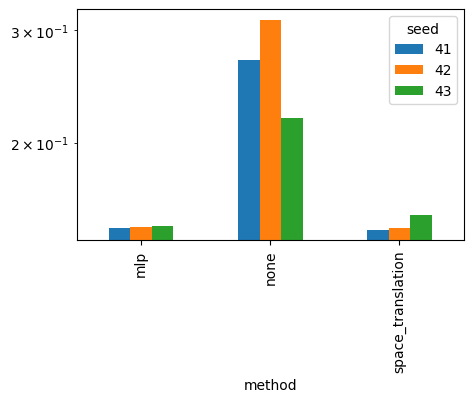

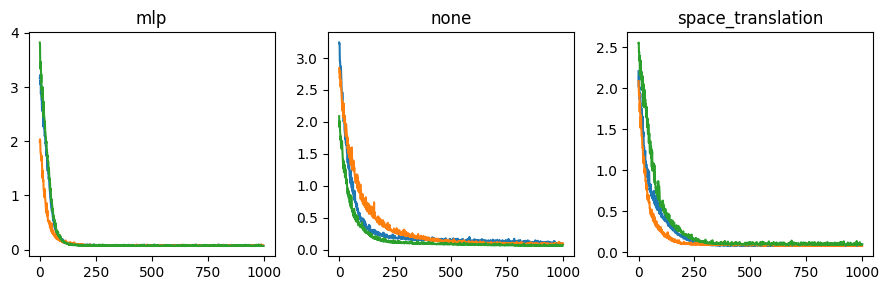

In [20]:
results = pd.DataFrame(rs)
results = results.set_index(['method']).sort_index()

results_testloss = results.pivot(columns = 'seed', values = 'test_loss')
results_losses = results.pivot(columns = 'seed', values = 'losses')

results_testloss.plot(kind = 'bar', figsize = (5, 3), logy=True)
n_plots = len(results_losses)
fig, axs = plt.subplots(1, n_plots, figsize = (3*n_plots, 3), tight_layout = True)
for ax, (method, losses) in zip(axs, results_losses.iterrows()):
    for losses_i in losses:
        ax.plot(losses_i)
        # ax.set_yscale('log')
    ax.set_title(method)


In [ ]:
# y_pred = y_pred.detach().squeeze(1)
# y_true = y.detach().squeeze(1)

# l_min, l_max = 0, 3
# plt.plot(y_true, y_pred, '.')
# plt.plot([l_min, l_max], [l_min, l_max], 'k--')
